In [ ]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
path = "../data/cleaned/final_merged_dataset.csv"   # change path if needed
df = pd.read_csv(path)
print("Dataset shape:", df.shape)
display(df.head())
print("Columns:", list(df.columns))


Dataset shape: (6930, 18)


,State,Crime_Type,Year,Cases,unemployment_rate,poverty_rate,per_capita_income,inflation_rate,population_density,gender_ratio,literacy_rate,youth_population_percent,urbanization_rate,human_development_index,police_stations_per_district,conviction_rate,police_personnel_per_100k,alcohol_consumption_per_capita
0,Andaman & Nicobar Islands,Burglary,2001,57,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
1,Andaman & Nicobar Islands,Dacoity,2001,7,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
2,Andaman & Nicobar Islands,Dowry Deaths,2001,0,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
3,Andaman & Nicobar Islands,Kidnapping & Abduction,2001,33,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3
4,Andaman & Nicobar Islands,Murder,2001,10,5.88,38.54,21691.8,4.4,10,915,61.94,24.0,22.0,0.535,6,37.0,59,2.3


Columns: ['State', 'Crime_Type', 'Year', 'Cases', 'unemployment_rate', 'poverty_rate', 'per_capita_income', 'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate', 'youth_population_percent', 'urbanization_rate', 'human_development_index', 'police_stations_per_district', 'conviction_rate', 'police_personnel_per_100k', 'alcohol_consumption_per_capita']


In [3]:
X = df.drop("Cases", axis=1)   # all columns except Cases
y = df["Cases"]                # target variable


In [ ]:
cat_cols = ["State", "Crime_Type"]
num_cols = [col for col in X.columns if col not in cat_cols]

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


Categorical columns: ['State', 'Crime_Type']
Numerical columns: ['Year', 'unemployment_rate', 'poverty_rate', 'per_capita_income', 'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate', 'youth_population_percent', 'urbanization_rate', 'human_development_index', 'police_stations_per_district', 'conviction_rate', 'police_personnel_per_100k', 'alcohol_consumption_per_capita']


In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)


In [6]:
train_df = df[df["Year"] <= 2020]
test_df  = df[df["Year"] >= 2021]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (6300, 18)
Test shape: (630, 18)


In [7]:

X_train = train_df.drop("Cases", axis=1)
y_train = train_df["Cases"]

X_test = test_df.drop("Cases", axis=1)
y_test = test_df["Cases"]


In [ ]:

preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)
print("Train shape:", X_train_transformed.shape)
print("Test shape:", X_test_transformed.shape)

Train shape: (6300, 59)
Test shape: (630, 59)


In [ ]:
# =======  Train a baseline Random Forest =======
rf = RandomForestRegressor(
    n_estimators=100,    # start with 100 trees
    max_depth=None,      # let trees grow fully (we'll tune later)
    random_state=42,
    n_jobs=-1
)

# Fit on training data (transformed)
rf.fit(X_train_transformed, y_train)

# Predict on train and test
y_train_pred = rf.predict(X_train_transformed)
y_test_pred  = rf.predict(X_test_transformed)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Baseline Random Forest (100 trees) Evaluation")
print(f"Train R²: {r2_train:.4f} | Test R²: {r2_test:.4f}")
print(f"Train MAE: {mae_train:.2f} | Test MAE: {mae_test:.2f}")
print(f"Train RMSE: {rmse_train:.2f} | Test RMSE: {rmse_test:.2f}")



✅ Baseline Random Forest (100 trees) Evaluation
Train R²: 0.9491 | Test R²: 0.6847
Train MAE: 449.41 | Test MAE: 1078.15
Train RMSE: 1841.97 | Test RMSE: 3940.96


In [28]:
param_dist = {
    'n_estimators': [200, 300, 400, 500, 600],

    # Control depth (best for preventing overfitting)
    'max_depth': [6, 8, 10, 12, 15, None],

    # Splitting controls (super important)
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],

    # Random feature selection
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],

    # Bootstrap improves stability
    'bootstrap': [True, False]
}


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,          # much better search
    cv=3,               # more stable than 2-fold
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_transformed, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV R²:", round(random_search.best_score_, 4))

best_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.3, 'max_depth': 8, 'bootstrap': True}
Best CV R²: 0.5708


In [30]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_test_pred = best_model.predict(X_test_transformed)

r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nOptimized Random Forest Performance:")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")



Optimized Random Forest Performance:
Test R²: 0.8023
Test MAE: 1059.69
Test RMSE: 3120.58


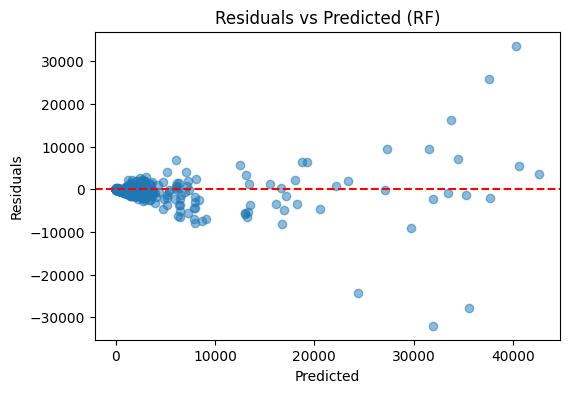

In [31]:
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (RF)")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


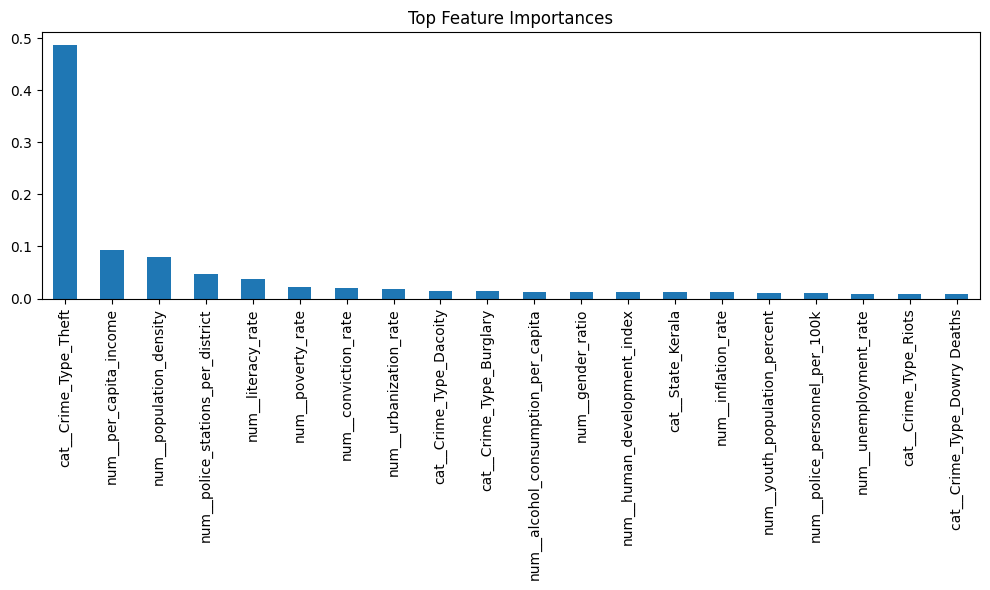

In [32]:
# Get feature names from the transformer
feature_names = preprocessor.get_feature_names_out()

# Get importances
importances = best_model.feature_importances_

# Create top-20 series
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
fi.plot.bar()
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


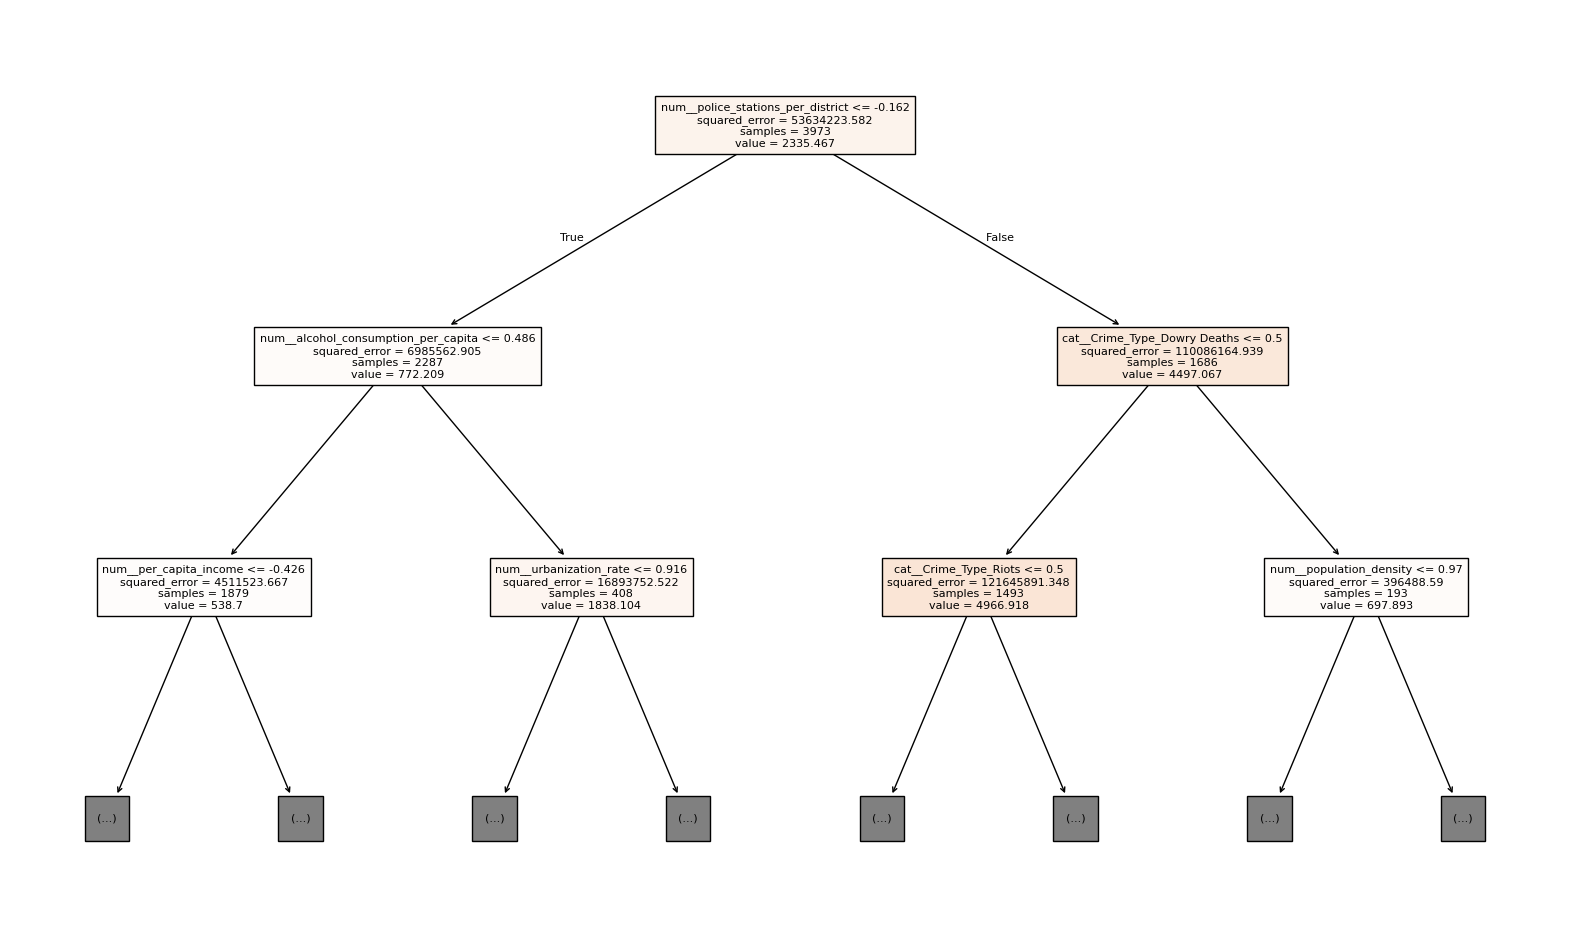

In [33]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# correct feature names
feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(20,12))
plot_tree(
    best_model.estimators_[0],
    max_depth=2, 
    feature_names=feature_names,
    filled=True,
    fontsize=8
)
plt.show()


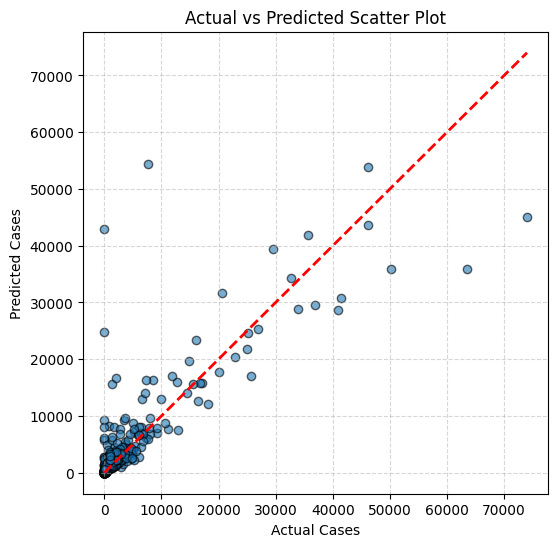

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Scatter Plot")
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [34]:
os.makedirs("../model", exist_ok=True)

# save trained model
joblib.dump(best_model, "../model/random_forest_time_model.pkl")



['../model/random_forest_time_model.pkl']